# Electricity Meter Reading Pipeline - Stage 3: Digit Recognition

This document describes the process for training a digit recognition model as part of an electricity meter reading pipeline.

## Preprocessing

The following steps are involved in preprocessing the images of the electricity meter counter:

1. **Input:** Take the output of Stage 2, which is an image of the counter area cropped from the original image.
2. **Straighten:** Use horizontal line detection (e.g., Hough Line Transform) to estimate the rotation angle and straighten the image. This ensures proper digit alignment.
3. **Convert to Binary:**
   - Convert the image to grayscale.
   - Apply binary thresholding to create a black and white (B/W) image.
   - Invert the binary image to make the digits white and the background black.
4. **Remove Borders:** Use horizontal line detection to identify and remove any remaining borders above and below the digits. This can be achieved using techniques like inpainting or morphological operations.
5. **Isolate Digits:** Apply edge detection (e.g., Canny edge detector) to identify the boundaries of the digits.
6. **Filter Contours:** Filter the resulting contours (detected digit boundaries) based on criteria such as:
   - Height > Width (digits are usually taller than they are wide)
   - Area (height * width) > threshold (to eliminate small noise or artifacts)
   - Other conditions as needed (e.g., aspect ratio, solidity)
7. **Extract and Save:** Extract each segmented digit and save it as a separate image file.

In [1]:
# Import the required libraries

import cv2
import os
import numpy as np
import glob
import math
from predict_helpers import *


In [2]:
# Define the source images:
# Note Shoulp be the "crop" output from Stage 2 Detection

image_path = "/Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_699*.jpg"
images = glob.glob(image_path)

if len(images) > 0:
    print(f"{len(images)} files matching {image_path} found")
else:
    print(f"No images found matching {image_path}")


36 files matching /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_699*.jpg found


In [12]:
def find_horizontal_lines(image):

    canny_threshold1= 120
    canny_threshold2= 250
    canny_apertureSize = 3
    horizontal_threshold=0.25

    print("Horizontal Lines")

    # Apply Canny edge detection
    img_edges = cv2.Canny(image, canny_threshold1, canny_threshold2, apertureSize=canny_apertureSize)
    plot_image(img_edges, f"Canny Edges - T1:{canny_threshold1}, T2:{canny_threshold2}, App:{canny_apertureSize}")

    # Detect lines using HoughLinesP
    lines = cv2.HoughLinesP(img_edges, 1, np.pi / 180.0, 100, minLineLength=100, maxLineGap=5)

    if lines is None:
        return 0  # No lines detected, assume no rotation
    l_no = 0
    horizontal_lines = []
    for [[x1, y1, x2, y2]] in lines:
        if x1 == x2: # Avoid divide by Zero Error
            continue
        
        slope = (y2 - y1) / (x2 - x1)
        try:
            length = int(math.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        except:
            print(f"\tValue Error in SQRT: [x1={x1}, y1={y1}]\t| [x2={x2}, y2={y2}]\t| (x2 - x1) = {x2 - x1}, (y2 - y1) = {y2 -y1}")
            length = 0
        # if abs(slope) < horizontal_threshold and (length > img_edges.shape[1] / 6):
        print(f"Line found [{l_no}]: [x1={x1}, y1={y1}]\t\t| [x2={x2}, y2={y2}]\t\t| Length={length}")
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        horizontal_lines.append([x1, y1, x2, y2, slope, length, angle])
        l_no += 1
            
    return horizontal_lines

# end def




In [26]:
def find_countours(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY) 

    image_bin_inv = cv2.bitwise_not(thresh)

    contours, contour_hierachie = cv2.findContours(image_bin_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_size_h, img_size_w, img_size_rgb = image.shape

    image_with_boxes = image.copy()

    # Draw bounding boxes
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 6)

    plot_image(image_with_boxes, "contours")

    return contours
# end def

Counter Image - Rotated by 0.000 degrees


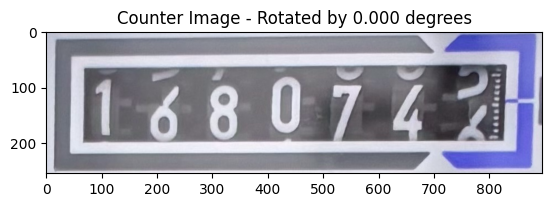

Looking for contours.....


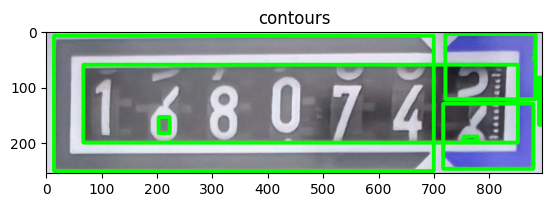

Print number of countours found: 10

-------------------------------------
Counter Image - Rotated by 3.743 degrees


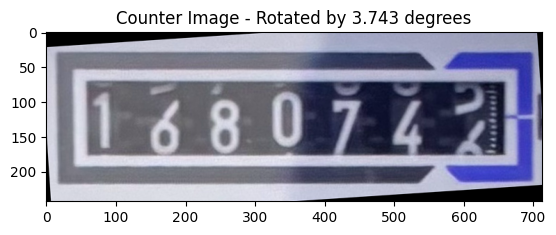

Looking for contours.....


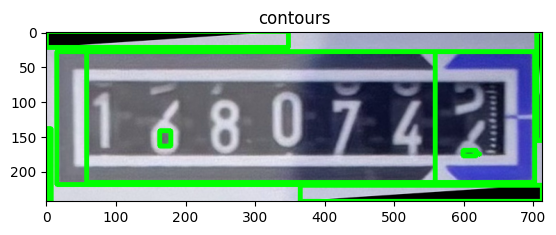

Print number of countours found: 9

-------------------------------------
Counter Image - Rotated by 3.743 degrees


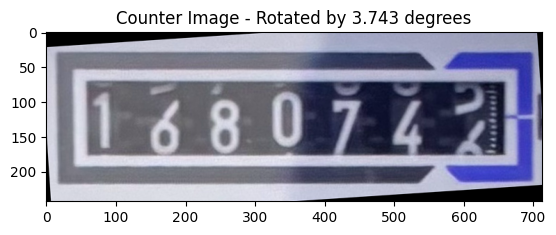

Looking for contours.....


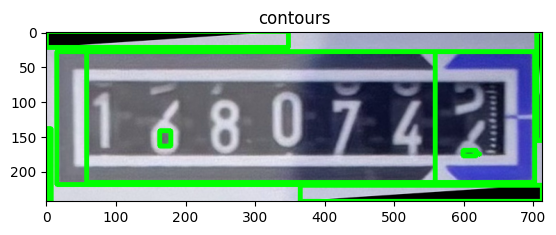

Print number of countours found: 9

-------------------------------------
Counter Image - Rotated by 0.000 degrees


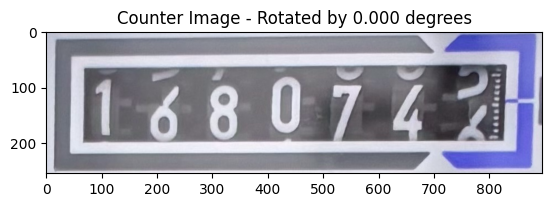

Looking for contours.....


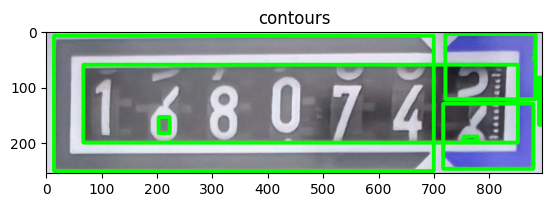

Print number of countours found: 10

-------------------------------------
Counter Image - Rotated by 0.000 degrees


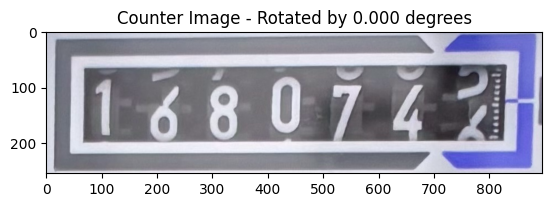

Looking for contours.....


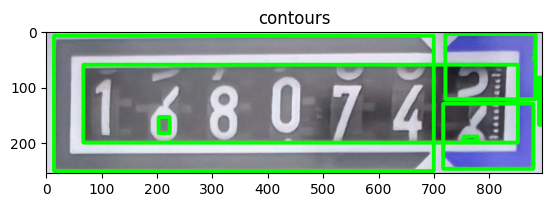

Print number of countours found: 10

-------------------------------------


In [27]:

# iterate over all the images
for img_no, img_path in enumerate(images):
    # 1 load the image
    image = load_image(img_path)
    # plot_image(image)

    # 2. Straighten
    #       Attemt to rotate the image so that the horizontal lines are straight,
    rotation_angle = determine_rotation_angle(image, horizontal_threshold=0.1)          
    image_rotated = rotate_image(image, rotation_angle)
    print(f"Counter Image - Rotated by {rotation_angle:.3f} degrees")
    plot_image(image_rotated, title=f"Counter Image - Rotated by {rotation_angle:.3f} degrees", bgr=False)

    # 3. Convert to Binary / Inverse
    #image_binary = convert_to_binary(image_rotated, bgr=False, invert=False)
    #print(f"Binary Image - Created: Shape: {image_binary.shape}. Dtype: {image_binary.dtype} - Rotation: {rotation_angle:.3f}")
    #plot_image(image_binary, title=f"Binary Image -", bgr=False)

    # 4 Remove Borders
    # Develop some magic here.....
    print("Looking for contours.....")
    countours = find_countours(image_rotated)
    print(f"Print number of countours found: {len(countours)}\n\n-------------------------------------")

    if img_no > 3:
        break
